In [1]:
import pyomo.environ as pyo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# search for "todo"

aktuell keine Unterscheidung möglich wenn H2 komplett umgewandelt wird, wie der Transport erfolgt ist

In [40]:
class hydro_opt:
    def __init__(self, input_data = None, h2_to_nh3_eff = None, h2_to_ch3oh_eff = None, h2_demand = None, nh3_demand = None, ch3oh_demand = None):
        # set default values for variables
        if input_data == None:
            #self.input_data = "Inputdata.xlsx"
            self.input_data = pd.read_excel("Inputdata.xlsx", index_col="Land", keep_default_na=False)
        else:
            self.input_data = input_data
        if h2_to_nh3_eff == None:
            self.h2_to_nh3_eff = 0.7
        else:
            self.h2_to_nh3_eff = h2_to_nh3_eff
        if h2_to_ch3oh_eff == None:
            self.h2_to_ch3oh_eff = 0.6
        else:
            self.h2_to_ch3oh_eff = h2_to_ch3oh_eff
        if h2_demand == None:
            self.h2_demand = 1000000
        else:
            self.h2_demand = h2_demand
        if nh3_demand == None:
            self.nh3_demand = 1000000
        else:
            self.nh3_demand = nh3_demand
        if ch3oh_demand == None:
            self.ch3oh_demand = 1000000
        else:
            self.ch3oh_demand = ch3oh_demand
        self.instance = None
        self.results_df = None
        
            
    def optimize(self, solve = "gurobi", show_model = False, return_model = False, return_as_df = False):
        """
        optimizes the given Model by minimizing the combined cost for:
            - import by ship and pipeline for H2, NH3 and CH3OH
            - conversion of H2 to NH3 or CH3OH 
        
        solve: string, default "gurobi"
            value for pyomo.environ.SolverFactory()
            defines the used Solver
        show_model: bool, default False
            if True: calls .display() on the optimized model to show the model in console
        return_model: bool, default False
            if True: returns the optimized pyomo model
        return_as_df: bool, default False
            if True: returns the optimized values as pandas DataFrame
            only used in combination with return_model=True
        """
        # set the optimization software to use
        solver = pyo.SolverFactory(solve) 
        # create the model and prepare to use the countries as Index
        model = pyo.ConcreteModel()
        model.country = self.input_data.index
        
        ### Params
        model.h2_price_production =  pyo.Param(model.country, initialize=self.input_data["H2 Herstellungspreis"].to_dict())
        model.h2_price_pipeline =  pyo.Param(model.country, initialize=self.input_data["H2 Pipeline Preis"].to_dict())
        model.h2_price_ship =  pyo.Param(model.country, initialize=self.input_data["H2 Schiff Preis"].to_dict())
        model.h2_export_limit = pyo.Param(model.country, initialize=self.input_data["H2 Export Limit"].to_dict())

        model.nh3_price_production =  pyo.Param(model.country, initialize=self.input_data["NH3 Herstellungspreis"].to_dict())
        model.nh3_price_pipeline =  pyo.Param(model.country, initialize=self.input_data["NH3 Pipeline Preis"].to_dict())
        model.nh3_price_ship =  pyo.Param(model.country, initialize=self.input_data["NH3 Schiff Preis"].to_dict())
        model.nh3_export_limit = pyo.Param(model.country, initialize=self.input_data["NH3 Export Limit"].to_dict())

        model.ch3oh_price_production =  pyo.Param(model.country, initialize=self.input_data["CH3OH Herstellungspreis"].to_dict())
        model.ch3oh_price_pipeline =  pyo.Param(model.country, initialize=self.input_data["CH3OH Pipeline Preis"].to_dict())
        model.ch3oh_price_ship =  pyo.Param(model.country, initialize=self.input_data["CH3OH Schiff Preis"].to_dict())
        model.ch3oh_export_limit = pyo.Param(model.country, initialize=self.input_data["CH3OH Export Limit"].to_dict())
        
        ### Variables
        model.h2_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.h2_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

        model.nh3_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.nh3_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

        model.ch3oh_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.ch3oh_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        
        model.h2_amount_to_nh3 = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        model.h2_amount_to_ch3oh = pyo.Var(model.country, domain = pyo.NonNegativeReals)
        
        ### objective function
        obj_expr = sum(
                # hydrogen demand + hydrogen for conversion to ammonia + hydrogen for conversion to methanol
                  (1+model.h2_amount_to_nh3[i]+model.h2_amount_to_ch3oh[i]) *
                # transport costs * quantity per transport option + production price * delivered amount
                  (model.h2_price_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_price_ship[i]*model.h2_amount_ship[i] + model.h2_price_production[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i]))
                + model.nh3_price_pipeline[i]*model.nh3_amount_pipeline[i] + model.nh3_price_ship[i]*model.nh3_amount_ship[i] + model.nh3_price_production[i]*(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i])                         
                + model.ch3oh_price_pipeline[i]*model.ch3oh_amount_pipeline[i] + model.ch3oh_price_ship[i]*model.ch3oh_amount_ship[i] + model.ch3oh_price_production[i]*(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i])
                for i in model.country) 
        model.obj = pyo.Objective(sense=pyo.minimize, expr=obj_expr)
        
        ### constraints
        # demand
        model.demand_constraints = pyo.ConstraintList()
        # hydrogen demand needs to be satisfied
        con_demand_h2_lhs = sum(model.h2_amount_pipeline[i] + model.h2_amount_ship[i] for i in model.country)  
        con_demand_h2_rhs = self.h2_demand
        model.demand_constraints.add(con_demand_h2_lhs >= con_demand_h2_rhs)
        # ammonia demand needs to be satisfied by imported ammonia and hydrogen converted to ammonia
        con_demand_nh3_lhs = sum(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i] + self.h2_to_nh3_eff*model.h2_amount_to_nh3[i] * (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) for i in model.country)
        con_demand_nh3_rhs = self.nh3_demand
        model.demand_constraints.add(con_demand_nh3_lhs >= con_demand_nh3_rhs)
        # methanol demand needs to be satisfied by imported methanol and hydrogen converted to methanol
        con_demand_ch3oh_lhs = sum(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i] + self.h2_to_ch3oh_eff*model.h2_amount_to_ch3oh[i] * (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) for i in model.country)
        con_demand_ch3oh_rhs = self.ch3oh_demand
        model.demand_constraints.add(con_demand_ch3oh_lhs >= con_demand_ch3oh_rhs)

        # export limits
        model.export_constraints = pyo.ConstraintList()

        for i in model.country:
            # hydrogen demand + hydrogen for conversion can't exceed export limit of country i
            con_export_h2_lhs = (model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) * (1 + model.h2_amount_to_nh3[i] + model.h2_amount_to_ch3oh[i])
            con_export_h2_rhs = model.h2_export_limit[i]
            model.export_constraints.add(con_export_h2_lhs <= con_export_h2_rhs)
            model.export_constraints.add(0 <= con_export_h2_lhs)

            con_export_nh3_lhs = model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]
            con_export_nh3_rhs = model.nh3_export_limit[i]
            model.export_constraints.add(con_export_nh3_lhs <= con_export_nh3_rhs)
            model.export_constraints.add(0 <= con_export_nh3_lhs)

            con_export_ch3oh_lhs = model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]
            con_export_ch3oh_rhs = model.ch3oh_export_limit[i]
            model.export_constraints.add(con_export_ch3oh_lhs <= con_export_h2_rhs)
            model.export_constraints.add(0 <= con_export_ch3oh_lhs)
            
        ### exchange
        #model.exchange_contraints = pyo.ContraintList()
        #for i in model.country:
        #    con_exchange_nh3_lhs = model.h2_amount_pipeline[i] + model.h2_amount_ship[i]
        #    con_exchange_nh3_rhs = model.h2_amount_to_nh3[i]
        #    model.exchange_constraints.add(con_exchange_nh3_lhs >=
            
        
        ### solve
        self.instance = model.create_instance()

        solver.options['NonConvex'] = 2
        results = solver.solve(self.instance)
        #print(results)
        
        self.results_df = pd.DataFrame(index = self.instance.country)
                
        opt_h2_amount_ship = {x:self.instance.h2_amount_ship[x].value for x in self.instance.country}
        opt_h2_amount_pipeline = {x:self.instance.h2_amount_pipeline[x].value for x in self.instance.country}
        opt_nh3_amount_ship = {x:self.instance.nh3_amount_ship[x].value for x in self.instance.country}
        opt_nh3_amount_pipeline = {x:self.instance.nh3_amount_pipeline[x].value for x in self.instance.country}
        opt_ch3oh_amount_ship = {x:self.instance.ch3oh_amount_ship[x].value for x in self.instance.country}
        opt_ch3oh_amount_pipeline = {x:self.instance.ch3oh_amount_pipeline[x].value for x in self.instance.country}
        opt_h2_amount_to_nh3 = {x:self.instance.h2_amount_to_nh3[x].value for x in self.instance.country}
        opt_h2_amount_to_ch3oh = {x:self.instance.h2_amount_to_ch3oh[x].value for x in self.instance.country}
                
        self.results_df["H2 Schiff"] = opt_h2_amount_ship
        self.results_df["H2 Pipeline"] = opt_h2_amount_pipeline
        self.results_df["H2 gesamt"] = self.results_df["H2 Pipeline"] + self.results_df["H2 Schiff"]
        self.results_df["NH3 Schiff"] = opt_nh3_amount_ship
        self.results_df["NH3 Pipeline"] = opt_nh3_amount_pipeline
        self.results_df["NH3 gesamt"] = self.results_df["NH3 Pipeline"] + self.results_df["NH3 Schiff"]
        self.results_df["CH3OH Schiff"] = opt_ch3oh_amount_ship
        self.results_df["CH3OH Pipeline"] = opt_ch3oh_amount_pipeline
        self.results_df["CH3OH gesamt"] = self.results_df["CH3OH Pipeline"] + self.results_df["CH3OH Schiff"]
        self.results_df["H2 zu NH3"] = opt_h2_amount_to_nh3
        self.results_df["H2 zu CH3OH"] = opt_h2_amount_to_ch3oh
        self.results_df["H2 für Umwandlung"] = opt_h2_amount_to_ch3oh
        self.results_df["Gesamter Import"] = self.results_df["H2 gesamt"] + self.results_df["NH3 gesamt"] + self.results_df["CH3OH gesamt"]
        
        if show_model:
            self.instance.display()
            
        if return_model:
            if return_as_df:                
                return self.results_df
            else:
                return self.instance
        
        
    def visualize(self, what="combined import", vis_style="map", figsize=(16,9), return_df = False):
        """
        Allows for visualisations of the results from the optimization. If different visualisations are needed, get the model results by calling ".optimize(return_model=True)"
        
        keywords:
            description
        """
        if self.instance == None:
            print("Es ist kein optimiertes Model vorhanden. Für die Visualisierung muss zuerst die Methode \".optimize()\" ausgeführt werden")
            pass
        # map needs aditional geometry
        if vis_style == "map":
            world = gpd.read_file("ne_110m_admin_0_countries.zip", include_fields=["ISO_A2_EH", "geometry"])
            vis_df = world.merge(self.results_df, how = "left", left_on="ISO_A2_EH", right_index=True).set_index("ISO_A2_EH")
        else:
            vis_df = self.results_df
            
        if what == "combined import":
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            ax.set_title("Gesamter Import")
            
            if vis_style=="map":
                vis_df.plot(column='Gesamter Import', cmap='viridis', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, legend_kwds={'shrink': 0.7})
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                # only show values > 0 for visivility / ease of interpretation
                positive_values = vis_df[vis_df["Gesamter Import"] > 0].sort_values(by="Gesamter Import",ascending=False)
                plt.bar(positive_values.index, positive_values['Gesamter Import'])
                for index, value in zip(positive_values.index, positive_values['Gesamter Import']):
                    plt.text(index, value + 0.1, str(int(value)), ha='center', va='bottom')
                # TODO unit
                ax.set_ylabel("MWh")
                ax.set_xlabel("Exportland")
                
            ax.set_title("Import von grünem Wasserstoff und wasserstoffbasierten Chemikalien nach Exportland")
        
        
        if return_df:
            return vis_df

        
        

In [20]:
t1=hydro_opt()

In [21]:
t1.optimize()

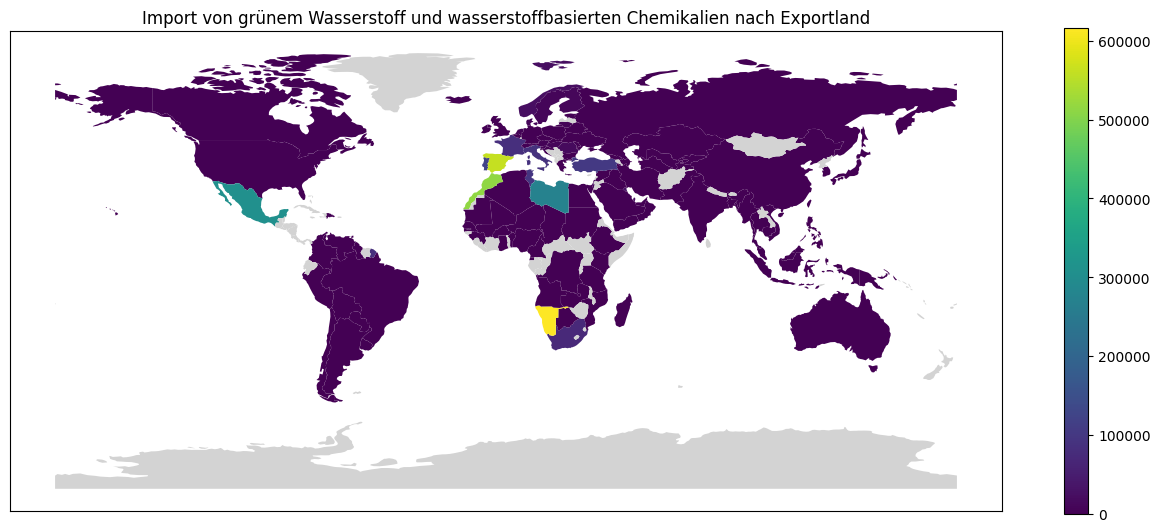

In [22]:
t11 = t1.visualize()

In [23]:
t11.loc["NA"]

geometry           POLYGON ((19.895767856534434 -24.7677902157605...
H2 Schiff                                                        0.0
H2 Pipeline                                                      0.0
H2 gesamt                                                        0.0
NH3 Schiff                                             231051.194365
NH3 Pipeline                                                     0.0
NH3 gesamt                                             231051.194365
CH3OH Schiff                                           384766.120574
CH3OH Pipeline                                                   0.0
CH3OH gesamt                                           384766.120574
Gesamter Import                                        615817.314939
H2 zu NH3                                                        0.0
H2 zu CH3OH                                                      0.0
Name: NA, dtype: object

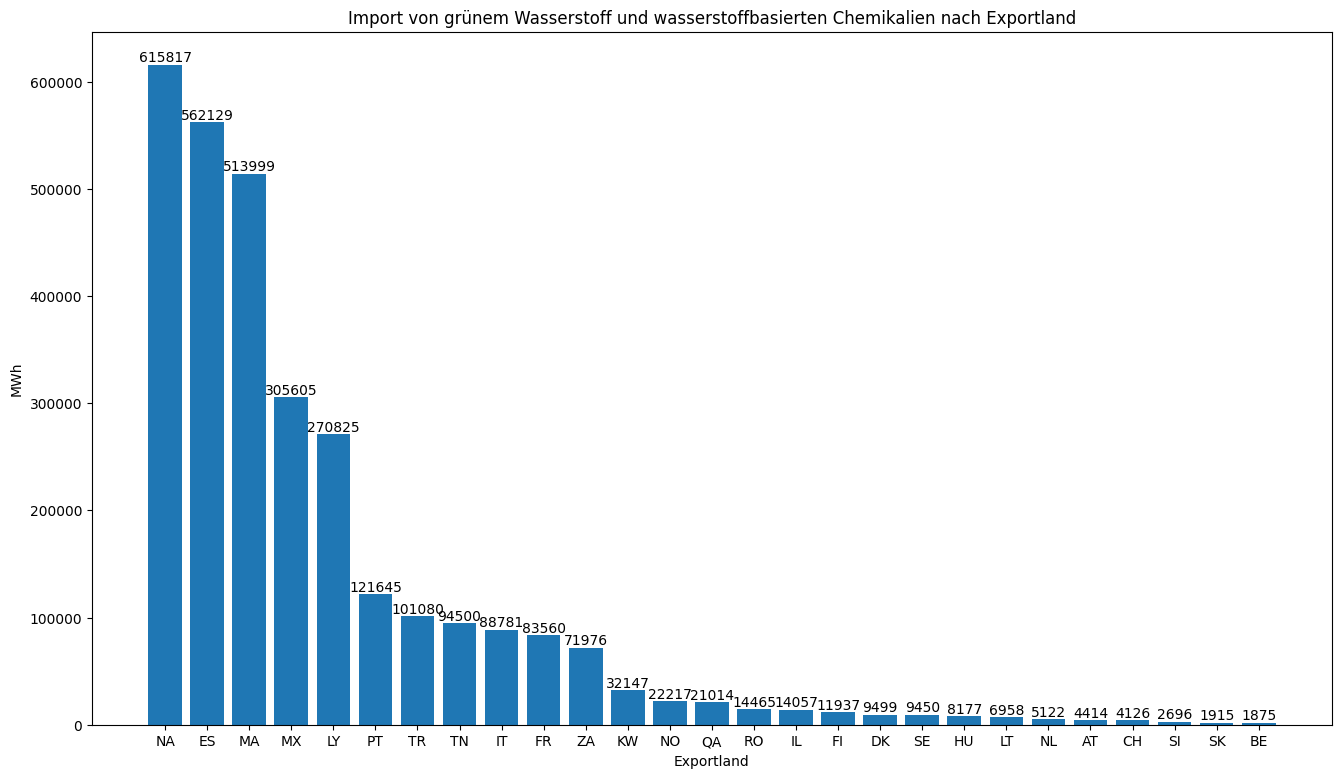

In [24]:
t12 = t1.visualize(vis_style = "bar")

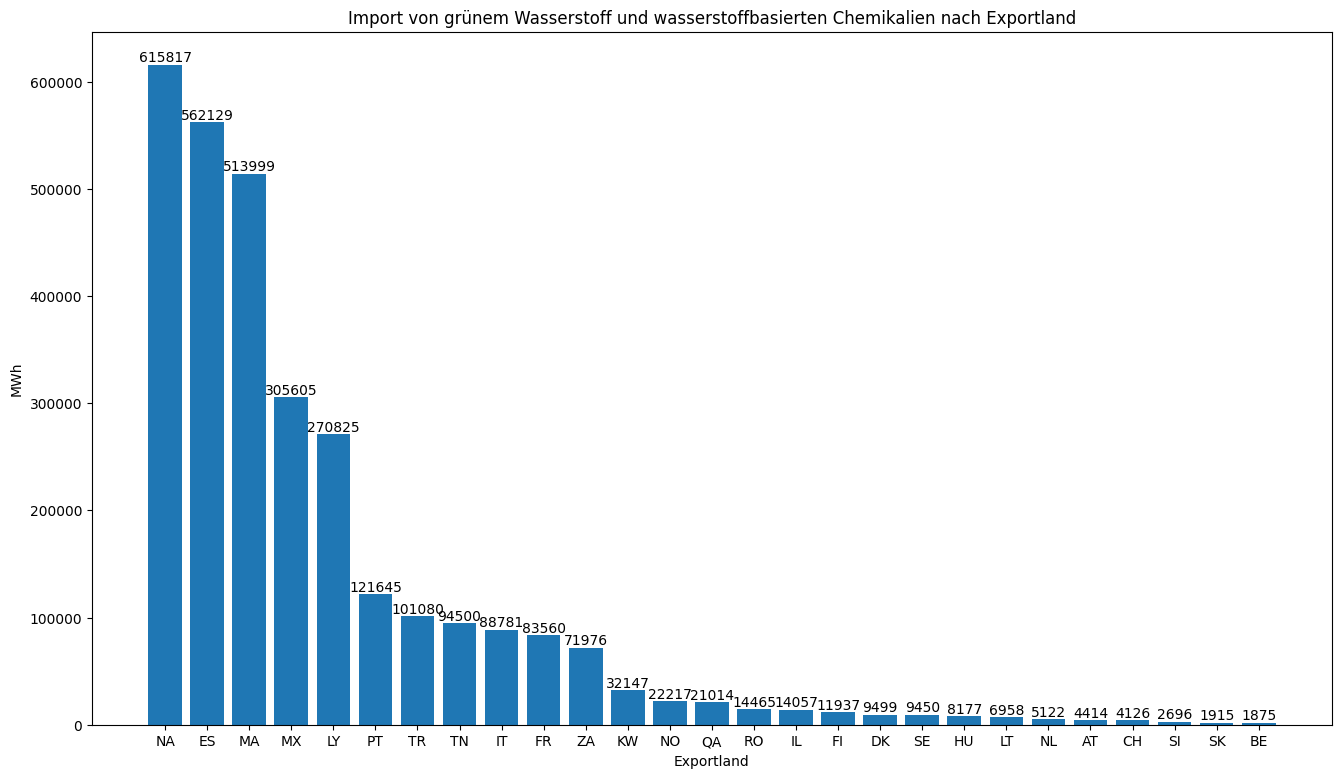

In [28]:
t22 = t2.visualize(vis_style = "bar")

In [31]:
t1.results_df["H2 zu NH3"].unique()

array([0.])

In [32]:
t1.results_df["H2 zu CH3OH"].unique()

array([0.])

In [42]:
t2 = hydro_opt(h2_to_nh3_eff=10)

In [43]:
t2.optimize()

In [44]:
t2.results_df["H2 zu NH3"].unique()

array([ 0.        , 17.05864367,  1.        ,  0.34794449,  1.        ,
        3.81493105, 16.43503504,  3.        ,  3.        ,  1.        ,
        0.21570372,  0.36641128])

In [45]:
t1.results_df["H2 zu CH3OH"].unique()

array([0.])

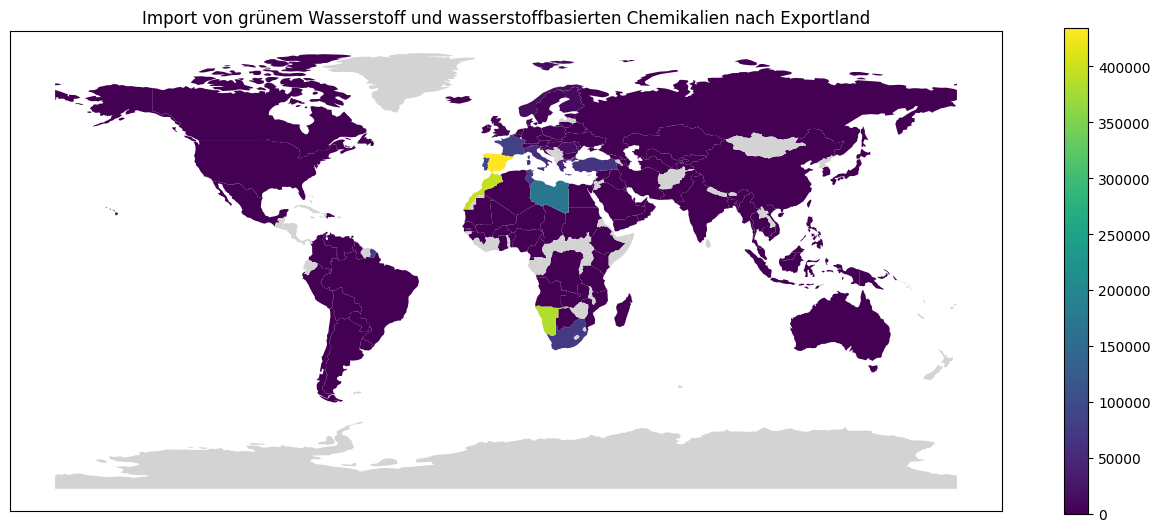

In [46]:
t2.visualize()

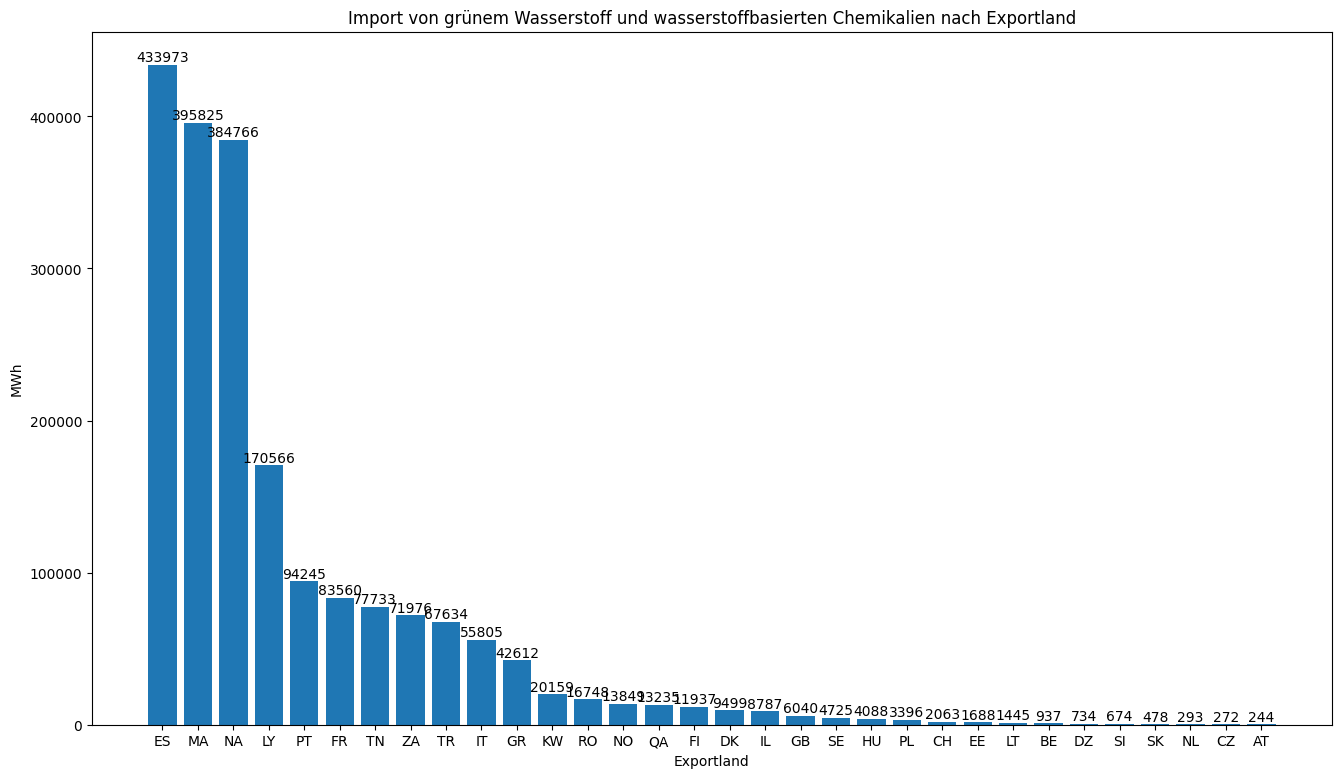

In [47]:
t2.visualize(vis_style="bar")